# DynamicHMCExamples for DynamicHMC.jl v2.0.0

黒木玄

2019-08-26～2019-09-03

2019年9月3日に

```
pkg> add LogDensityProblems
pkg> add DynamicHMC
```

した状態で

https://github.com/tpapp/DynamicHMCExamples.jl/tree/master/src

にあるexamplesを動くようにしたノートブック.

DynamicHMC.jl は v2.0.0 から仕様が大幅に変化するので, 現在公開されているexamplesがそのままでは動かない.  それを修正してみたのが, このノートブックです.

In [1]:
]status LogDensityProblems

    Status `C:\Users\genkuroki\.julia\environments\v1.2\Project.toml`
  [6e4b80f9] BenchmarkTools v0.4.3
  [6fdf6af0] LogDensityProblems v0.9.1
  [d96e819e] Parameters v0.12.0
  [84d833dd] TransformVariables v0.3.5


In [2]:
]status DynamicHMC

    Status `C:\Users\genkuroki\.julia\environments\v1.2\Project.toml`
  [bbc10e6e] DynamicHMC v2.0.1
  [6fdf6af0] LogDensityProblems v0.9.1
  [429524aa] Optim v0.19.3
  [d96e819e] Parameters v0.12.0
  [4c63d2b9] StatsFuns v0.8.0


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Bernoulli" data-toc-modified-id="Bernoulli-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bernoulli</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Logistic regression</a></span></li><li><span><a href="#Linear-regression" data-toc-modified-id="Linear-regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Linear regression</a></span></li></ul></div>

In [3]:
using Distributions
using TransformVariables
using LogDensityProblems
using DynamicHMC
using DynamicHMC.Diagnostics
using MCMCDiagnostics
using Parameters
using Statistics
using Random
using Plots
gr(size=(400, 250), titlefontsize=12)
using ForwardDiff
using StatsFuns
using LinearAlgebra

## Bernoulli

https://github.com/tpapp/DynamicHMCExamples.jl/blob/master/src/example_independent_bernoulli.jl

In [4]:
# # Estimate Bernoulli draws probabilility

# We estimate a simple model of ``n`` independent Bernoulli draws, with
# probability ``α``. First, we load the packages we use.

# using TransformVariables
# using LogDensityProblems
# using DynamicHMC
# using MCMCDiagnostics
# using Parameters
# using Statistics

# Then define a structure to hold the data.
# For this model, the number of draws equal to `1` is a sufficient statistic.

"""
Toy problem using a Bernoulli distribution.
We model `n` independent draws from a ``Bernoulli(α)`` distribution.
"""
struct BernoulliProblem
    "Total number of draws in the data."
    n::Int
    "Number of draws `==1` in the data"
    s::Int
end

# Then make the type callable with the parameters *as a single argument*.  We
# use decomposition in the arguments, but it could be done inside the function,
# too.

function (problem::BernoulliProblem)((α, )::NamedTuple{(:α, )})
    @unpack n, s = problem        # extract the data
    # log likelihood: the constant log(combinations(n, s)) term
    # has been dropped since it is irrelevant to sampling.
    s * log(α) + (n-s) * log(1-α)
end

# We should test this, also, this would be a good place to benchmark and
# optimize more complicated problems.

p = BernoulliProblem(30, 10)
p((α = 0.5, ))

-20.79441541679836

In [5]:
# Recall that we need to
#
# 1. transform from ``ℝ`` to the valid parameter domain `(0,1)` for more efficient sampling, and
#
# 2. calculate the derivatives for this transformed mapping.
#
# The helper packages `TransformVariables` and `LogDensityProblems` take care of
# this. We use a flat prior (the default, omitted)


trans = as((α = as𝕀,))
P = TransformedLogDensity(trans, p)
∇P = ADgradient(:ForwardDiff, P);

display(trans)
display(P)
display(∇P)

TransformVariables.TransformTuple{NamedTuple{(:α,),Tuple{TransformVariables.ScaledShiftedLogistic{Float64}}}}((α = TransformVariables.ScaledShiftedLogistic{Float64}(1.0, 0.0),), 1)

TransformedLogDensity of dimension 1

ForwardDiff AD wrapper for TransformedLogDensity of dimension 1, w/ chunk size 1

In [6]:
# Finally, we sample from the posterior. `chain` holds the chain (positions and
# diagnostic information), while the second returned value is the tuned sampler
# which would allow continuation of sampling.

L = 1000

#chain, NUTS_tuned = NUTS_init_tune_mcmc(∇P, L)
@time results = mcmc_with_warmup(Random.GLOBAL_RNG, ∇P, L; reporter = NoProgressReport());

display(results.chain)

 11

1000-element Array{Array{Float64,1},1}:
 [-0.46789567795367226] 
 [-0.46789567795367226] 
 [-0.5444278174503668]  
 [-1.2311528140855235]  
 [-1.019041864042111]   
 [0.015026319661229803] 
 [0.015026319661229803] 
 [-0.5994572041703292]  
 [-0.7516990561737176]  
 [-0.7313786249366536]  
 [-0.7135270705966078]  
 [-0.3116546072202764]  
 [-0.007753336119741938]
 ⋮                      
 [-0.42133064583878754] 
 [-0.2740846741025077]  
 [-0.13960203744725688] 
 [-0.7276391482367761]  
 [-0.04970800381731888] 
 [-0.5833024665299135]  
 [-0.61680577282707]    
 [-0.61680577282707]    
 [-0.5929877701486542]  
 [-0.17262426284320415] 
 [-0.07814599147007643] 
 [-0.07814599147007643] 

.546129 seconds (20.23 M allocations: 1.027 GiB, 7.75% gc time)


In [7]:
# To get the posterior for ``α``, we need to use `get_position` and
# then transform

#posterior = transform.(Ref(t), get_position.(chain));
posterior = transform.(trans, results.chain)

1000-element Array{NamedTuple{(:α,),Tuple{Float64}},1}:
 (α = 0.38511442919352307,)
 (α = 0.38511442919352307,)
 (α = 0.3671581615695588,) 
 (α = 0.22597971999627567,)
 (α = 0.26521407581606354,)
 (α = 0.5037565092336334,) 
 (α = 0.5037565092336334,) 
 (α = 0.3544678867216671,) 
 (α = 0.3204511977514769,) 
 (α = 0.32489227060210485,)
 (α = 0.3288199554526439,) 
 (α = 0.42271091947829703,)
 (α = 0.49806167568012616,)
 ⋮                         
 (α = 0.39619838215922226,)
 (α = 0.4319045896305402,) 
 (α = 0.4651560609394176,) 
 (α = 0.32571301373713113,)
 (α = 0.4875755572217636,) 
 (α = 0.35817305069890354,)
 (α = 0.35050827666345147,)
 (α = 0.35050827666345147,)
 (α = 0.35594961512293,)   
 (α = 0.4569507836882297,) 
 (α = 0.480473438182007,)  
 (α = 0.480473438182007,)  

In [8]:
# Extract the parameter.

posterior_α = first.(posterior)

1000-element Array{Float64,1}:
 0.38511442919352307
 0.38511442919352307
 0.3671581615695588 
 0.22597971999627567
 0.26521407581606354
 0.5037565092336334 
 0.5037565092336334 
 0.3544678867216671 
 0.3204511977514769 
 0.32489227060210485
 0.3288199554526439 
 0.42271091947829703
 0.49806167568012616
 ⋮                  
 0.39619838215922226
 0.4319045896305402 
 0.4651560609394176 
 0.32571301373713113
 0.4875755572217636 
 0.35817305069890354
 0.35050827666345147
 0.35050827666345147
 0.35594961512293   
 0.4569507836882297 
 0.480473438182007  
 0.480473438182007  

In [9]:
# check the mean

mean(posterior_α)

0.3483625893602138

In [10]:
# check the effective sample size

ess_α = effective_sample_size(posterior_α)

304.2677505485877

In [11]:
# NUTS-specific statistics

#NUTS_statistics(chain)
summarize_tree_statistics(results.tree_statistics)

Hamiltonian Monte Carlo sample of length 1000
  acceptance rate mean: 0.91, 5/25/50/75/95%: 0.64 0.87 0.96 1.0 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 64%, 2 => 36%

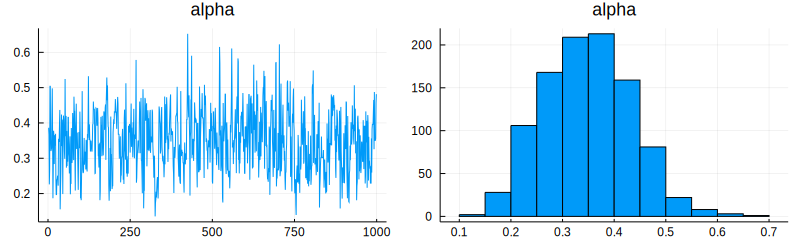

In [12]:
P1 = plot(posterior_α)
P2 = histogram(posterior_α)
plot(P1, P2, size=(800, 250), title="alpha", legend=false)

## Logistic regression

https://github.com/tpapp/DynamicHMCExamples.jl/blob/master/src/example_logistic_regression.jl

In [13]:
# # Logistic regression

#using TransformVariables, LogDensityProblems, DynamicHMC, MCMCDiagnostics, Parameters,
#    Distributions, Statistics, StatsFuns, ForwardDiff

"""
Logistic regression.
For each draw, ``logit(Pr(yᵢ == 1)) ∼ Xᵢ β``. Uses a `β ∼ Normal(0, σ)` prior.
`X` is supposed to include the `1`s for the intercept.
"""
struct LogisticRegression{Ty, TX, Tσ}
    y::Ty
    X::TX
    σ::Tσ
end

function (problem::LogisticRegression)(θ)
    @unpack y, X, σ = problem
    @unpack β = θ
    loglik = sum(logpdf.(Bernoulli.(logistic.(X*β)), y))
    logpri = sum(logpdf.(Ref(Normal(0, σ)), β))
    loglik + logpri
end

# Make up parameters, generate data using random draws.

N = 1000
β = [1.0, 2.0]
X = hcat(ones(N), randn(N))
y = rand.(Bernoulli.(logistic.(X*β)));

In [14]:
# Create a problem, apply a transformation, then use automatic differentiation.

p = LogisticRegression(y, X, 10.0)   # data and (vague) priors

LogisticRegression{BitArray{1},Array{Float64,2},Float64}(Bool[1, 1, 1, 1, 0, 0, 1, 0, 1, 0  …  0, 1, 0, 0, 0, 0, 1, 0, 1, 1], [1.0 0.3144800192469527; 1.0 -0.058950292262223675; … ; 1.0 0.6109022911410555; 1.0 0.5168451748474543], 10.0)

In [15]:
trans = as((β = as(Array, length(β)), )) # identity transformation, just to get the dimension
P = TransformedLogDensity(trans, p)      # transformed
∇P = ADgradient(:ForwardDiff, P)

display(trans)
display(P)
display(∇P)

TransformVariables.TransformTuple{NamedTuple{(:β,),Tuple{TransformVariables.ArrayTransform{TransformVariables.Identity,1}}}}((β = TransformVariables.ArrayTransform{TransformVariables.Identity,1}(TransformVariables.Identity(), (2,)),), 2)

TransformedLogDensity of dimension 2

ForwardDiff AD wrapper for TransformedLogDensity of dimension 2, w/ chunk size 2

In [16]:
# Sample using NUTS, random starting point.

#chain, NUTS_tuned = NUTS_init_tune_mcmc(∇P, 1000);

L = 10^3
@time results = mcmc_with_warmup(Random.GLOBAL_RNG, ∇P, L; reporter = NoProgressReport());
display(results.chain)

1000-element Array{Array{Float64,1},1}:
 [0.7930881549552842, 2.146205409458534] 
 [1.0258003674794138, 2.0476789254229053]
 [0.8254862726350796, 2.3475089321124]   
 [1.08692088027854, 2.291881528066267]   
 [0.9494925979871794, 2.2843327035669336]
 [0.9212383829473461, 2.3628687932551555]
 [0.889713478863422, 1.9825536116689797] 
 [0.889713478863422, 1.9825536116689797] 
 [0.9511077027260666, 2.258185345575461] 
 [0.9805724620327994, 2.2518853657085414]
 [0.9292149130744184, 2.25009058160918]  
 [1.0090833547741913, 2.3237318060954397]
 [0.9256613896616963, 2.3053635832943074]
 ⋮                                       
 [0.9513508919676565, 2.1715478487807274]
 [0.911863290813344, 2.2140853070409414] 
 [0.9945432273015248, 2.218192511861939] 
 [0.9641183258543049, 2.207567443065789] 
 [0.9339685235460888, 2.1847957418590895]
 [0.8027912970041508, 2.3163557174701856]
 [0.7641695108059471, 2.3372469068885433]
 [0.8361803712166854, 2.3272572673902934]
 [0.9757046328849801, 1.947428332254

  3.107447 seconds (4.42 M allocations: 606.754 MiB, 6.48% gc time)


In [17]:
# Extract the posterior. Here the transformation was not really necessary.

posterior = transform.(trans, results.chain)

1000-element Array{NamedTuple{(:β,),Tuple{Array{Float64,1}}},1}:
 (β = [0.7930881549552842, 2.146205409458534],) 
 (β = [1.0258003674794138, 2.0476789254229053],)
 (β = [0.8254862726350796, 2.3475089321124],)   
 (β = [1.08692088027854, 2.291881528066267],)   
 (β = [0.9494925979871794, 2.2843327035669336],)
 (β = [0.9212383829473461, 2.3628687932551555],)
 (β = [0.889713478863422, 1.9825536116689797],) 
 (β = [0.889713478863422, 1.9825536116689797],) 
 (β = [0.9511077027260666, 2.258185345575461],) 
 (β = [0.9805724620327994, 2.2518853657085414],)
 (β = [0.9292149130744184, 2.25009058160918],)  
 (β = [1.0090833547741913, 2.3237318060954397],)
 (β = [0.9256613896616963, 2.3053635832943074],)
 ⋮                                              
 (β = [0.9513508919676565, 2.1715478487807274],)
 (β = [0.911863290813344, 2.2140853070409414],) 
 (β = [0.9945432273015248, 2.218192511861939],) 
 (β = [0.9641183258543049, 2.207567443065789],) 
 (β = [0.9339685235460888, 2.1847957418590895],)
 (β 

In [18]:
β_posterior = first.(posterior)

1000-element Array{Array{Float64,1},1}:
 [0.7930881549552842, 2.146205409458534] 
 [1.0258003674794138, 2.0476789254229053]
 [0.8254862726350796, 2.3475089321124]   
 [1.08692088027854, 2.291881528066267]   
 [0.9494925979871794, 2.2843327035669336]
 [0.9212383829473461, 2.3628687932551555]
 [0.889713478863422, 1.9825536116689797] 
 [0.889713478863422, 1.9825536116689797] 
 [0.9511077027260666, 2.258185345575461] 
 [0.9805724620327994, 2.2518853657085414]
 [0.9292149130744184, 2.25009058160918]  
 [1.0090833547741913, 2.3237318060954397]
 [0.9256613896616963, 2.3053635832943074]
 ⋮                                       
 [0.9513508919676565, 2.1715478487807274]
 [0.911863290813344, 2.2140853070409414] 
 [0.9945432273015248, 2.218192511861939] 
 [0.9641183258543049, 2.207567443065789] 
 [0.9339685235460888, 2.1847957418590895]
 [0.8027912970041508, 2.3163557174701856]
 [0.7641695108059471, 2.3372469068885433]
 [0.8361803712166854, 2.3272572673902934]
 [0.9757046328849801, 1.947428332254

In [19]:
# Check that we recover the parameters.

mean(β_posterior)

2-element Array{Float64,1}:
 0.9672810645538743
 2.2583458612167484

In [20]:
# Quantiles

qs = [0.05, 0.25, 0.5, 0.75, 0.95]
quantile(first.(β_posterior), qs)

5-element Array{Float64,1}:
 0.809577195069061 
 0.9006658322827379
 0.9666099873118109
 1.0281303162332933
 1.1380073514335531

In [21]:
quantile(last.(β_posterior), qs)

5-element Array{Float64,1}:
 2.0292832437927593
 2.160270123623224 
 2.252210774849514 
 2.3524133844677118
 2.5049595470047703

In [22]:
# Check that mixing is good.

ess = vec(mapslices(effective_sample_size, reduce(hcat, β_posterior); dims = 2))

2-element Array{Float64,1}:
 287.47237942176497
 576.6971704785094 

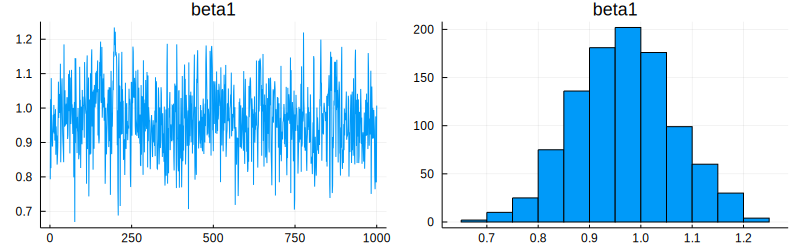

In [23]:
P1 = plot(first.(β_posterior))
P2 = histogram(first.(β_posterior))
plot(P1, P2, size=(800, 250), title="beta1", legend=false)

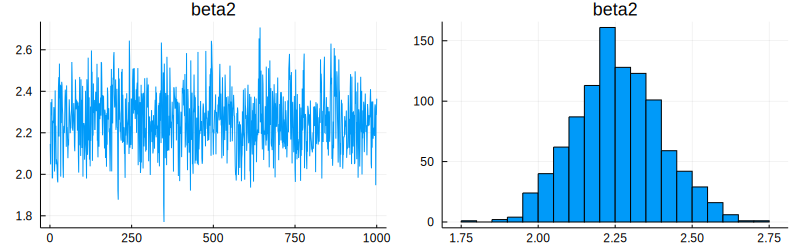

In [24]:
P1 = plot(last.(β_posterior))
P2 = histogram(last.(β_posterior))
plot(P1, P2, size=(800, 250), title="beta2", legend=false)

## Linear regression

https://github.com/tpapp/DynamicHMCExamples.jl/blob/master/src/example_linear_regression.jl

In [25]:
Random.seed!(4649);

In [26]:
# # Linear regression

# We estimate simple linear regression model with a half-T prior.
# First, we load the packages we use.

# using TransformVariables, LogDensityProblems, DynamicHMC, MCMCDiagnostics,
#     Parameters, Statistics, Distributions, ForwardDiff

# Then define a structure to hold the data: observables, covariates, and the degrees of freedom for the prior.

"""
Linear regression model ``y ∼ Xβ + ϵ``, where ``ϵ ∼ N(0, σ²)`` IID.
Flat prior for `β`, half-T for `σ`.
"""
struct LinearRegressionProblem{TY <: AbstractVector, TX <: AbstractMatrix,
                               Tν <: Real}
    "Observations."
    y::TY
    "Covariates"
    X::TX
    "Degrees of freedom for prior."
    ν::Tν
end

# Then make the type callable with the parameters *as a single argument*.

function (problem::LinearRegressionProblem)(θ)
    @unpack y, X, ν = problem   # extract the data
    @unpack β, σ = θ            # works on the named tuple too
    loglikelihood(Normal(0, σ), y .- X*β) + logpdf(TDist(ν), σ)
end

# We should test this, also, this would be a good place to benchmark and
# optimize more complicated problems.

#N = 100
N = 5
#X = hcat(ones(N), randn(N, 2));
x = rand(Uniform(-2, 2), N)
X = hcat(ones(N), x, x.^2);
β = [1.0, 2.0, -1.0]
#σ = 0.5
σ = 1.0
y = X*β .+ randn(N) .* σ;
p = LinearRegressionProblem(y, X, 1.0);
p((β = β, σ = σ))

-8.66067388411468

In [27]:
law_true(β, x) = β[1] + β[2]*x + β[3]*x^2

law_true (generic function with 1 method)

In [28]:
# For this problem, we write a function to return the transformation (as it varies with the number of covariates).

problem_transformation(p::LinearRegressionProblem) =
    as((β = as(Array, size(p.X, 2)), σ = asℝ₊))

# Wrap the problem with a transformation, then use Flux for the gradient.

trans = problem_transformation(p)
P = TransformedLogDensity(trans, p)
∇P = ADgradient(:ForwardDiff, P);

display(trans)
display(P)
display(∇P)

TransformVariables.TransformTuple{NamedTuple{(:β, :σ),Tuple{TransformVariables.ArrayTransform{TransformVariables.Identity,1},TransformVariables.ShiftedExp{true,Float64}}}}((β = TransformVariables.ArrayTransform{TransformVariables.Identity,1}(TransformVariables.Identity(), (3,)), σ = TransformVariables.ShiftedExp{true,Float64}(0.0)), 4)

TransformedLogDensity of dimension 4

ForwardDiff AD wrapper for TransformedLogDensity of dimension 4, w/ chunk size 4

In [29]:
# Finally, we sample from the posterior. `chain` holds the chain (positions and
# diagnostic information), while the second returned value is the tuned sampler
# which would allow continuation of sampling.

L = 2^11

#chain, NUTS_tuned = NUTS_init_tune_mcmc(∇P, 1000);
@time results = mcmc_with_warmup(Random.GLOBAL_RNG, ∇P, L; reporter = NoProgressReport());

display(results.chain)

2048-element Array{Array{Float64,1},1}:
 [2.155236637715731, 2.276885382687765, -2.405799991161668, -0.026423651643289886]   
 [0.8820321795383079, 3.0212328765154846, -0.5618133793781922, -0.004902014225516546]
 [2.4194049021984343, 2.55065541878323, -1.5632131693136735, -0.5622425312719688]    
 [2.3968779790619363, 2.547629848709332, -1.8933837910342768, -0.7875575047524692]   
 [1.8108060493982405, 2.6194940163512688, -1.5599553724130153, -0.8356061154124103]  
 [1.6352654905648003, 2.2287819978326167, -0.8514132082678891, -0.3172430261277607]  
 [1.3805405147788343, 2.5364486664376904, -1.0544689245288086, -0.3515475318997308]  
 [1.7542226751642724, 2.9090911507435044, -0.834325244521887, -0.9076302213569245]   
 [1.7542226751642724, 2.9090911507435044, -0.834325244521887, -0.9076302213569245]   
 [1.7932355670131965, 2.9631232626530988, -0.8476248978752932, -0.7381073563444712]  
 [1.7366224656644038, 3.002286653916178, -0.8320695984275652, -0.782626556716755]    
 [1.8991116615

  2.163095 seconds (4.72 M allocations: 277.822 MiB, 6.77% gc time)


In [30]:
# We use the transformation to obtain the posterior from the chain.

#posterior = transform.(Ref(t), get_position.(chain));
posterior = transform.(trans, results.chain)

2048-element Array{NamedTuple{(:β, :σ),Tuple{Array{Float64,1},Float64}},1}:
 (β = [2.155236637715731, 2.276885382687765, -2.405799991161668], σ = 0.9739223983717544)    
 (β = [0.8820321795383079, 3.0212328765154846, -0.5618133793781922], σ = 0.9951099810378956) 
 (β = [2.4194049021984343, 2.55065541878323, -1.5632131693136735], σ = 0.5699295448771747)   
 (β = [2.3968779790619363, 2.547629848709332, -1.8933837910342768], σ = 0.4549546639106049)  
 (β = [1.8108060493982405, 2.6194940163512688, -1.5599553724130153], σ = 0.43361158310415593)
 (β = [1.6352654905648003, 2.2287819978326167, -0.8514132082678891], σ = 0.7281537732290381) 
 (β = [1.3805405147788343, 2.5364486664376904, -1.0544689245288086], σ = 0.7035984057982967) 
 (β = [1.7542226751642724, 2.9090911507435044, -0.834325244521887], σ = 0.4034792484944173)  
 (β = [1.7542226751642724, 2.9090911507435044, -0.834325244521887], σ = 0.4034792484944173)  
 (β = [1.7932355670131965, 2.9631232626530988, -0.8476248978752932], σ = 0.478

In [31]:
# Extract the parameter posterior means: `β`,

posterior_β = first.(posterior)
@show mean_posterior_β = mean(posterior_β)

# then `σ`:

posterior_σ = last.(posterior)
@show mean_posterior_σ = mean(posterior_σ)

display(posterior_β)
display(posterior_σ)

mean_posterior_β = mean(posterior_β) = [2.013516797685997, 2.654850591438265, -1.4369117371295437]


2048-element Array{Array{Float64,1},1}:
 [2.155236637715731, 2.276885382687765, -2.405799991161668]   
 [0.8820321795383079, 3.0212328765154846, -0.5618133793781922]
 [2.4194049021984343, 2.55065541878323, -1.5632131693136735]  
 [2.3968779790619363, 2.547629848709332, -1.8933837910342768] 
 [1.8108060493982405, 2.6194940163512688, -1.5599553724130153]
 [1.6352654905648003, 2.2287819978326167, -0.8514132082678891]
 [1.3805405147788343, 2.5364486664376904, -1.0544689245288086]
 [1.7542226751642724, 2.9090911507435044, -0.834325244521887] 
 [1.7542226751642724, 2.9090911507435044, -0.834325244521887] 
 [1.7932355670131965, 2.9631232626530988, -0.8476248978752932]
 [1.7366224656644038, 3.002286653916178, -0.8320695984275652] 
 [1.8991116615238328, 2.3409011393973977, -1.4646188489578165]
 [1.890704956627292, 2.2777254740897224, -1.331159664760753]  
 ⋮                                                            
 [4.1508940004638974, 2.510220063518032, -2.98526624859857]   
 [2.36211158886

2048-element Array{Float64,1}:
 0.9739223983717544 
 0.9951099810378956 
 0.5699295448771747 
 0.4549546639106049 
 0.43361158310415593
 0.7281537732290381 
 0.7035984057982967 
 0.4034792484944173 
 0.4034792484944173 
 0.47801777722045496
 0.4572035617594826 
 0.5144115600972012 
 0.547344709440526  
 ⋮                  
 1.1079272792281842 
 1.0984466966714403 
 0.7671306718392836 
 0.5662275870021227 
 0.6130539042321534 
 0.5920980789404265 
 0.7340700962141409 
 0.43453778918916014
 0.4152334456237136 
 0.3854629662278223 
 0.368443756707755  
 0.368443756707755  

mean_posterior_σ = mean(posterior_σ) = 0.9789830905249814


In [32]:
# Effective sample sizes (of untransformed draws)

ess = mapslices(effective_sample_size, hcat(results.chain...); dims = 2)

4×1 Array{Float64,2}:
 791.3528955331897 
 871.4063925694975 
 950.9268389580166 
 273.55168445607535

In [33]:
# NUTS-specific statistics

#NUTS_statistics(chain)
summarize_tree_statistics(results.tree_statistics)

Hamiltonian Monte Carlo sample of length 2048
  acceptance rate mean: 0.81, 5/25/50/75/95%: 0.12 0.75 0.93 0.98 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 2%, 2 => 14%, 3 => 47%, 4 => 34%, 5 => 2%, 6 => 0%

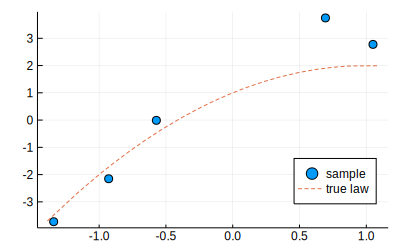

In [34]:
scatter(X[:,2], y, label="sample", legend=:bottomright)
plot!(x -> law_true(β, x), label="true law", ls=:dash)

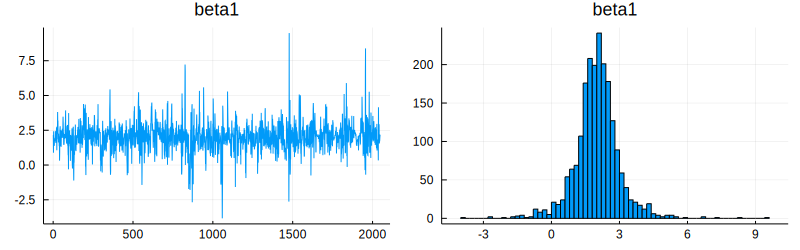

In [35]:
P1 = plot((x->x[1]).(posterior_β))
P2 = histogram((x->x[1]).(posterior_β))
plot(P1, P2, size=(800, 250), title="beta1", legend=false)

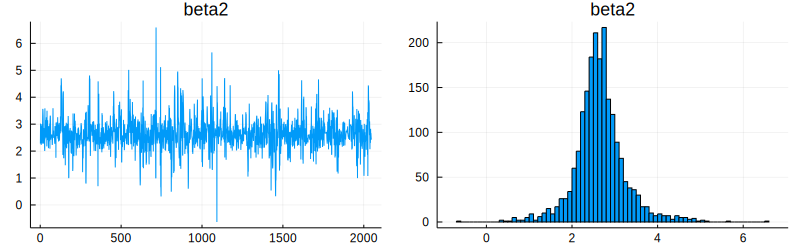

In [36]:
P1 = plot((x->x[2]).(posterior_β))
P2 = histogram((x->x[2]).(posterior_β))
plot(P1, P2, size=(800, 250), title="beta2", legend=false)

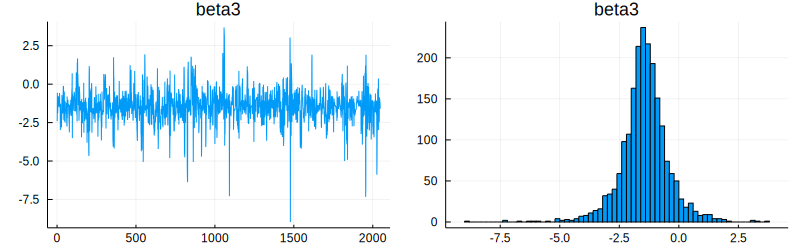

In [37]:
P1 = plot((x->x[3]).(posterior_β))
P2 = histogram((x->x[3]).(posterior_β))
plot(P1, P2, size=(800, 250), title="beta3", legend=false)

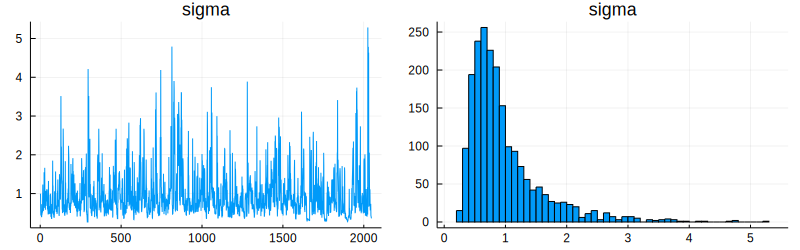

In [38]:
P1 = plot(posterior_σ)
P2 = histogram(posterior_σ)
plot(P1, P2, size=(800, 250), title="sigma", legend=false)

In [39]:
function pred_linreg(posterior, x, y)
    L = length(posterior)
    β = first.(posterior)
    σ = last.(posterior)
    mean(pdf(Normal(0.0, σ[i]), y - (β[i][1] + β[i][2]*x + β[i][3]*x^2)) for i in 1:L)
end

pred_linreg (generic function with 1 method)

In [40]:
@show a = (X'X)\X'*y
@show s = fit_mle(Normal, y - X*a).σ
pred_linreg_mle(a, s, x, y) = pdf(Normal(0.0, s), y - (a[1] + a[2]*x + a[3]*x^2))

a = ((X' * X) \ X') * y = [1.9898026341763784, 2.630342130669235, -1.4074843029322044]
s = (fit_mle(Normal, y - X * a)).σ = 0.42454239399788624


pred_linreg_mle (generic function with 1 method)

  1.487970 seconds (528.88 k allocations: 339.034 MiB, 7.95% gc time)
  0.111731 seconds (183.94 k allocations: 7.868 MiB, 10.88% gc time)


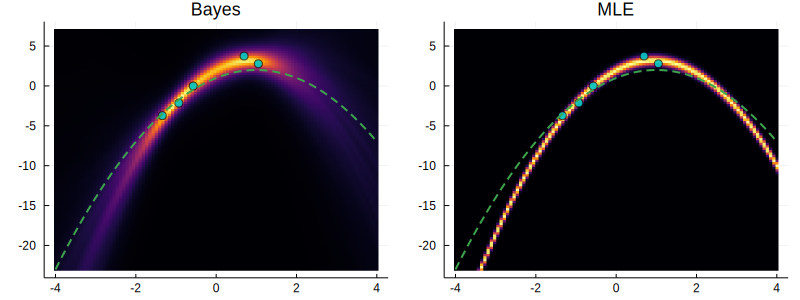

In [41]:
xs = range(-4, 4, length=100)
ys = range(-23, 7, length=100)

@time zs = [pred_linreg(posterior, x, y) for y in ys, x in xs]
P1 = plot(; size=(400, 300))
heatmap!(xs, ys, zs, colorbar=false)
scatter!(X[:,2], y, label="sample", legend=false, markersize=4, color=:cyan, alpha=0.7)
plot!(xs, [law_true(β, x) for x in xs], ls=:dash, lw=2)
title!("Bayes")

@time zs = [pred_linreg_mle(a, s, x, y) for y in ys, x in xs]
P2 = plot(; size=(400, 300))
heatmap!(xs, ys, zs, colorbar=false)
scatter!(X[:,2], y, label="sample", legend=false, markersize=4, color=:cyan, alpha=0.7)
plot!(xs, [law_true(β, x) for x in xs], ls=:dash, lw=2)
title!("MLE")

plot(P1, P2, size=(800, 300))

In [42]:
2N*mean(-log(pred_linreg(posterior, X[i,2], y[i])) for i in 1:N) 

10.32801037165634

In [43]:
2N*mean(-log(pred_linreg_mle(a, s, X[i,2], y[i])) for i in 1:N) 

5.621951230625681